In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from sklearn.utils import shuffle
from tensorflow.keras import utils
from tensorflow import concat
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

2023-10-11 02:32:36.635629: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 02:32:36.682158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 02:32:37.366041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])#这一步是读取图片
    labels = np.array(F['ans'])#这一步是读取图片的标签
    
images = images.astype(np.float32)#这一步是将图片转为float32类型   

labels = utils.to_categorical(labels, 10)#这一步是使用one-hot编码，一个10个类
labels = labels.astype(np.float32)#这一步是图片将图片的标签转为float32类型

In [3]:
(images, labels) = shuffle(images, labels)#这一步是打乱图片和其标签的排列顺序

In [4]:
#classes是类对应的英文名字，是否正确对应未检查。
classes = ['Disturbed Galaxies','Merging Galaxies','Round Smooth Galaxies','In-between Round Smooth Galaxies','Cigar Shaped Smooth Galaxies','Barred Spiral Galaxies','Unbarred Tight Spiral Galaxies','Unbarred Loose Spiral Galaxies','Edge-on Galaxies without Bulge','Edge-on Galaxies with Bulge']
class_labels = {classes:i for classes, i in enumerate(classes)}#生成类别名字到标号的对应关系，是否正确对应未检查。
print(class_labels)

{0: 'Disturbed Galaxies', 1: 'Merging Galaxies', 2: 'Round Smooth Galaxies', 3: 'In-between Round Smooth Galaxies', 4: 'Cigar Shaped Smooth Galaxies', 5: 'Barred Spiral Galaxies', 6: 'Unbarred Tight Spiral Galaxies', 7: 'Unbarred Loose Spiral Galaxies', 8: 'Edge-on Galaxies without Bulge', 9: 'Edge-on Galaxies with Bulge'}


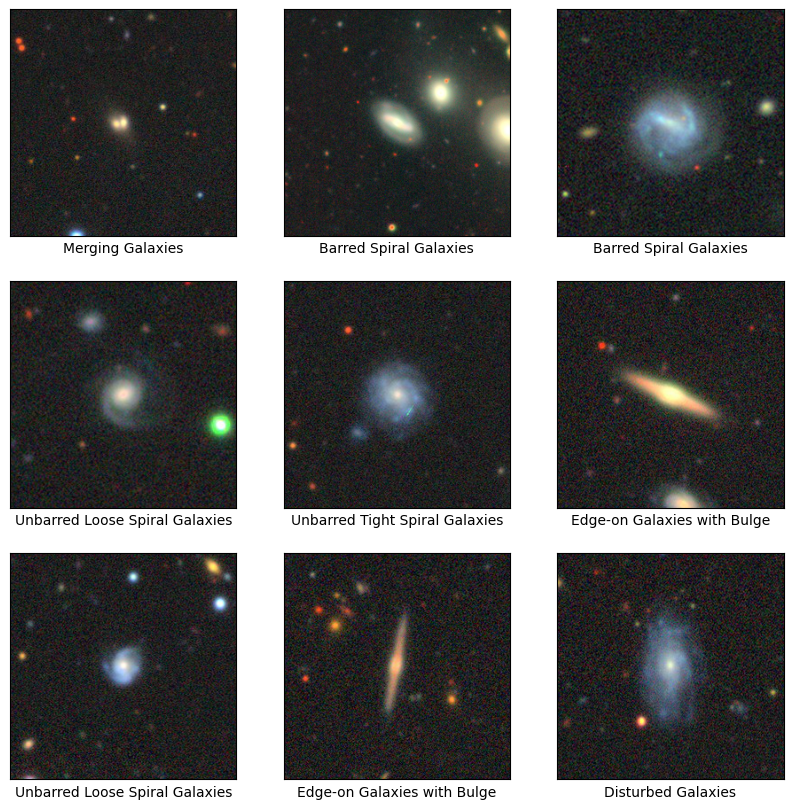

In [5]:
#显示图片及其类别
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i]/255.)
    plt.xlabel(class_labels[int(np.argwhere(labels[i]==1))])
plt.show()

In [6]:
#SeNet的特征
class SeBlock(Model):
    def __init__(self, planes):
        super(SeBlock, self).__init__()
        self.se = Sequential()
        self.se.add(GlobalAveragePooling2D(keepdims=True))
        self.se.add(Conv2D(planes,kernel_size=(1,1),strides=(1, 1),padding='same'))
        self.se.add(Activation('gelu'))
        self.se.add(Conv2D(planes,kernel_size=(1,1),strides=(1, 1),padding='same'))
        self.se.add(Activation('sigmoid'))
    def call(self, inputs):
        out = self.se(inputs)
        return out

In [7]:
#ResNet的特征
class BasicBlock(Model):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.basic = Sequential()
        self.basic.add(Conv2D(planes,kernel_size=(3,3),strides=(stride, stride),padding='same')) 
        self.basic.add(BatchNormalization())
        self.basic.add(Activation('gelu'))
        self.basic.add(Conv2D(planes,kernel_size=(3,3),strides=(1, 1),padding='same'))
        self.basic.add(BatchNormalization())
        self.se1 = SeBlock(planes=planes)
        self.shortcut = Sequential()
        if in_planes!=planes or stride!=1:
            self.shortcut.add(Conv2D(planes,kernel_size=(1,1),strides=(stride, stride),padding='same'))
            self.shortcut.add(BatchNormalization())
        self.a2 = Activation('gelu')
    def call(self, inputs):
        out = self.basic(inputs)
        w = self.se1(out)
        out = out * w
        residual=self.shortcut(inputs)
        out = self.a2(residual+out)
        return out

In [8]:
#DlaNet的特征
class Root(Model):
    def __init__(self, planes, kernel_size=1):
        super(Root, self).__init__()
        self.basic = Sequential()
        self.basic.add(Conv2D(planes,kernel_size=(kernel_size,kernel_size),strides=(1, 1),padding='same'))
        self.basic.add(BatchNormalization())
        self.basic.add(Activation('gelu'))
    def call(self, inputs):
        out = concat(inputs, axis=-1)
        out = self.basic(out)
        return out

In [9]:
#DlaNet的特征
class Tree(Model):
    def __init__(self, in_planes, planes, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(planes)
            self.left_node = BasicBlock(in_planes, planes, stride=stride)
            self.right_node = BasicBlock(planes, planes, stride=1)
        else:
            self.root = Root(planes)
            self.subtrees={}
            for i in reversed(range(1, level)):
                if i==level-1:
                    subtree = Tree(in_planes, planes, level=i, stride=stride)
                else:
                    subtree = Tree(planes, planes, level=i, stride=stride)
                self.subtrees[f'level_{i}'] = subtree
            self.prev_root = BasicBlock(in_planes, planes, stride=stride)
            self.left_node = BasicBlock(planes, planes, stride=1)
            self.right_node = BasicBlock(planes, planes, stride=1)
    def call(self, inputs):
        out = inputs
        outs = [self.prev_root(out)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.subtrees[f'level_{i}']
            out = level_i(out)
            outs.append(out)
        out = self.left_node(out)
        outs.append(out)
        out = self.right_node(out)
        outs.append(out)
        out = self.root(outs)
        return out

In [10]:
#该模型没有同池化操作下采样，处理SeNet生成权值w部分，使用激活函数包括sigmoid，tanh，gelu
class CNN_net(Model):
    def __init__(self, model):
        super(CNN_net, self).__init__()
        self.stem = Sequential()
        self.stem.add(Conv2D(16,kernel_size=(5,5),strides=(1, 1),padding='same'))#256
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('gelu'))
        self.stem.add(Conv2D(32,kernel_size=(3,3),strides=(1, 1),padding='same'))#256
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('gelu'))
        self.stem.add(Conv2D(32,kernel_size=(3,3),strides=(2, 2),padding='same'))#128
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('gelu'))
        
        self.blocks = Sequential()
        self.blocks.add(Tree(32,  64, level=2, stride=1))##128
        self.blocks.add(Tree(64,  128, level=2, stride=2))#64
        self.blocks.add(Tree(128,  256, level=2, stride=2))#32
        self.blocks.add(Tree(256,  512, level=2, stride=2))#16
        self.blocks.add(Tree(512,  1024, level=2, stride=2))#8
        self.blocks.add(Tree(1024,  2048, level=2, stride=2))#4
        self.blocks.add(Conv2D(2048,kernel_size=(4,4),strides=(1, 1),padding='valid'))#1
        self.blocks.add(BatchNormalization())
        self.blocks.add(Activation('gelu'))
        
        self.fullconnected = Sequential()
        self.fullconnected.add(Flatten())
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        
        self.out = Sequential()
        if model=='regression':
            self.out.add(Dense(1, activation='linear'))
        if model=='classification':
            self.out.add(Dense(10, activation='softmax'))
        
    def call(self, inputs):
        out = self.stem(inputs)
        out = self.blocks(out)
        out = self.fullconnected(out)
        out = self.out(out)
        return out

In [11]:
model_classification = CNN_net(model='classification')#生成用于classification的模型

2023-10-11 02:33:54.230389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-11 02:33:54.262634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-11 02:33:54.263064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
model_classification.build(input_shape=(None, 256, 256, 3))#定义模型的input_shape
model_classification.summary()#生成模型的总结

Model: "cnn_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 32)      15424     
                                                                 
 sequential_1 (Sequential)   (None, 1, 1, 2048)        615363584 
                                                                 
 sequential_104 (Sequential  (None, 1024)              4209664   
 )                                                               
                                                                 
 sequential_105 (Sequential  (None, 10)                10250     
 )                                                               
                                                                 
Total params: 619598922 (2.31 GB)
Trainable params: 619475626 (2.31 GB)
Non-trainable params: 123296 (481.62 KB)
_________________________________________________________________


In [13]:
#这里是使用SGDR的参数
#initial_learning_rate = 0.1
#first_decay_steps = 1000
#t_mul = 2.0
#m_mul = 1.0
#alpha = 0.0

In [14]:
#这里是使用SGDR编译模型
#checkpoint_save_path = r'saved_modle_classification'
#lr_reducer = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate, first_decay_steps, t_mul=2.0, m_mul=1.0, alpha=0.0)
#model_classification.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=lr_reducer,momentum=0.9,nesterov=True,weight_decay=5e-4),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=tf.keras.metrics.CategoricalAccuracy())

In [15]:
#这里是使用AdamW编译模型，并用ReduceLROnPlateau调整训练中的学习率
model_classification.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00008),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=tf.keras.metrics.CategoricalAccuracy())
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=10,mode='min',min_lr=1e-20)

In [16]:
checkpoint_save_path = 'modelsave-mixuptrain1.h5'#这里是模型的路径
model_classification.load_weights(filepath=checkpoint_save_path)#这里是加载模型

In [17]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,#将输入数据的每个样本减去整个数据集的均值，使得数据的均值为0。这有助于使数据集的均值接近于零。
    featurewise_std_normalization=True,#将输入数据的每个样本除以整个数据集的标准差，以使数据的标准差为1。这有助于使数据的标准差接近于1。
    rotation_range=180,#在范围内随机旋转图像，以增加数据的多样性。此参数指定旋转范围为±180度，即任意角度的旋转。
    width_shift_range=0.2,#在水平方向随机平移图像。此参数指定允许图像水平平移的范围为图像宽度的20%。
    height_shift_range=0.2,#在垂直方向随机平移图像。此参数指定允许图像垂直平移的范围为图像高度的20%。
    horizontal_flip=True,#随机水平翻转图像。这可以增加数据的多样性和泛化能力。
    rescale=1/255.,#对输入图像进行缩放，将像素值从0-255缩放到0-1范围之间。这通常是在训练之前对图像进行预处理的常见步骤。
    validation_split=0.2,#指定验证集的比例。在此情况下，20% 的数据将用作验证集，而剩余的 80% 将用于训练。
)

train_datagen.fit(images)#调用 fit 方法来计算输入图像数据的统计信息，包括均值和标准差。这将使用整个数据集来计算这些统计信息，并将它们应用于后续的数据增强和预处理过程中。

In [18]:
def mixup(batch_x, batch_y, alpha):
    batch_size = len(batch_x)
    lam = np.random.beta(alpha, alpha, size=batch_size)

    index = np.random.permutation(batch_size)
    mixed_x = lam.reshape(batch_size, 1, 1, 1) * batch_x + (1 - lam.reshape(batch_size, 1, 1, 1)) * batch_x[index]
    mixed_y = lam.reshape(batch_size, 1) * batch_y + (1 - lam.reshape(batch_size, 1)) * batch_y[index]

    return mixed_x, mixed_y

In [19]:
def datagen_generator(images, labels, batch_size, alpha):
    generator = train_datagen.flow(images, labels, batch_size=batch_size,subset='training')
    while True:
        batch_x, batch_y = next(generator)#next(generator) 返回的是使用 train_datagen.flow 生成器生成的下一个批次的图像数据和对应的标签。
        mixed_x, mixed_y = mixup(batch_x, batch_y, alpha)#调用mixup方法生成训练数据与标签
        yield mixed_x, mixed_y#通过使用 yield 语句返回混合后的图像数据和标签，即 yield mixed_x, mixed_y。这样，datagen_generator 函数就变成了一个生成器函数，每次调用它时，都会生成一个新的批次的混合数据。

In [20]:
batch_size = 16#batch_size大小为16
alpha = 1#alpha为1，代表着beta分布中各个概率出现的可能性相同

In [21]:
#checkpointer的作用是在训练中保存模型
checkpointer = ModelCheckpoint(filepath=checkpoint_save_path,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)
history_classification = model_classification.fit(datagen_generator(images, labels, batch_size, alpha),
                                                    validation_data=train_datagen.flow(images, labels,batch_size=batch_size, subset='validation'),
                                                    steps_per_epoch=880,
                                                    epochs=200,
                                                    callbacks=[lr_reducer, checkpointer]#调整学习率和保存模型
                                                 )


Epoch 1/200


2023-10-11 02:36:39.079222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2023-10-11 02:36:41.668390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-11 02:36:41.980686: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbb03a76460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-11 02:36:41.980795: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-11 02:36:41.993009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-11 02:36:42.126929: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

880/880 [==============================] - ETA: 0s - loss: 1.1114 - categorical_accuracy: 0.7413
Epoch 1: val_loss improved from inf to 0.55678, saving model to modelsave-mixuptrain1.h5
880/880 [==============================] - 619s 597ms/step - loss: 1.1114 - categorical_accuracy: 0.7413 - val_loss: 0.5568 - val_categorical_accuracy: 0.8385 - lr: 8.0000e-05
Epoch 2/200
  6/880 [..............................] - ETA: 7:01 - loss: 1.0103 - categorical_accuracy: 0.7708

2023-10-11 02:46:26.223151: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-11 02:46:26.345459: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-11 02:46:26.345593: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-11 02:46:26.595282: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

880/880 [==============================] - ETA: 0s - loss: 1.1127 - categorical_accuracy: 0.7430
Epoch 2: val_loss improved from 0.55678 to 0.54523, saving model to modelsave-mixuptrain1.h5
880/880 [==============================] - 508s 578ms/step - loss: 1.1127 - categorical_accuracy: 0.7430 - val_loss: 0.5452 - val_categorical_accuracy: 0.8385 - lr: 8.0000e-05
Epoch 3/200
880/880 [==============================] - ETA: 0s - loss: 1.1283 - categorical_accuracy: 0.7414
Epoch 3: val_loss did not improve from 0.54523
880/880 [==============================] - 463s 526ms/step - loss: 1.1283 - categorical_accuracy: 0.7414 - val_loss: 0.5551 - val_categorical_accuracy: 0.8373 - lr: 8.0000e-05
Epoch 4/200
880/880 [==============================] - ETA: 0s - loss: 1.1280 - categorical_accuracy: 0.7350
Epoch 4: val_loss did not improve from 0.54523
880/880 [==============================] - 464s 528ms/step - loss: 1.1280 - categorical_accuracy: 0.7350 - val_loss: 0.5512 - val_categorical_accu

UnknownError: Graph execution error:

Detected at node 'cnn_net/sequential_1/conv2d_147/Conv2D' defined at (most recent call last):
    File "/root/miniconda3/envs/myconda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/root/miniconda3/envs/myconda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/root/miniconda3/envs/myconda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/root/miniconda3/envs/myconda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/root/miniconda3/envs/myconda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_146/1437132307.py", line 3, in <module>
      history_classification = model_classification.fit(datagen_generator(images, labels, batch_size, alpha),
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_146/3845710425.py", line 47, in call
      out = self.blocks(out)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/root/miniconda3/envs/myconda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'cnn_net/sequential_1/conv2d_147/Conv2D'
CUDNN failed to allocate the scratch space for the runner or to find a working no-scratch runner.
	 [[{{node cnn_net/sequential_1/conv2d_147/Conv2D}}]] [Op:__inference_train_function_84907]

In [ ]:
print(history_classification.history)

In [ ]:
fig1 = plt.figure(num="model regularize", figsize=(8, 6))
ax1 = fig1.add_subplot(111)
ax1.plot(history_classification.history['categorical_accuracy'], label='train accuracy', color='b')
ax1.plot(history_classification.history['val_categorical_accuracy'], label='val accuracy', color='g')
ax1.legend(loc = 'upper center')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy');
ax2 = ax1.twinx()
ax2.plot(history_classification.history['loss'], label="train loss", color='r')
ax2.plot(history_classification.history['val_loss'], label="val loss", color='y')
ax2.legend(loc=2)
ax2.set_ylabel('loss');
ax2.legend(loc = 'lower center')
plt.show()